In [1]:
import environment

In [2]:
import sb3_contrib
import torch
import gymnasium as gym
import stable_baselines3 as sb3

In [3]:
device = "cpu" if not torch.cuda.is_available() else "cuda:0"
# env = gym.make("Regression_Env", device=device, action_low=[0,-.001,0.0], action_high=[1,.1,0.6]) #making the action space more friendly

env = gym.make("NORTH_Regression_Env", device=device,seed=1, action_low=[0,-.001,0.0,.4,0.0,0.0], action_high=[1,.1,0.6,1.0,1.0,1.0]) #making the action space more friendly
env = gym.wrappers.FlattenObservation(env)
model = sb3_contrib.RecurrentPPO("MlpLstmPolicy", env, verbose=1)
model.set_logger(sb3.common.logger.configure('./sb3_log', ["stdout", "csv", "tensorboard"]))
model.learn(10000,log_interval=5)

/home/fioritjx/.cache/pypoetry/virtualenvs/sad-nns-aEsqIT8E-py3.11/lib/python3.11/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `NORTH_Regression_Env-v1` instead of the unversioned environment `NORTH_Regression_Env`.
  logger.warn(


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./sb3_log


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA__native_batch_norm)

In [ ]:
import pandas as pd

/tmp/ipykernel_2994723/4080736814.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
df = pd.read_csv('./sb3_log/progress.csv')

In [ ]:
df.head()

,train/approx_kl,train/n_updates,train/clip_range,rollout/ep_rew_mean,time/total_timesteps,train/clip_fraction,time/iterations,train/std,time/fps,train/loss,train/explained_variance,rollout/ep_len_mean,time/time_elapsed,train/policy_gradient_loss,train/entropy_loss,train/learning_rate,train/value_loss
0,0.004427,40,0.2,-0.007888,640,0.003125,5,0.993910,5,-0.010256,-1.854931,2.93,121,-0.006971,-4.242402,0.0003,0.019266
1,0.014929,90,0.2,0.029910,1280,0.067969,10,0.986728,5,-0.032516,0.050830,3.40,236,-0.020237,-4.218651,0.0003,0.011752
2,0.001381,140,0.2,0.028605,1920,0.000000,15,0.982196,5,-0.010326,-0.205670,5.26,364,-0.006953,-4.204716,0.0003,0.013647
3,0.015340,190,0.2,0.056798,2560,0.123438,20,0.980102,5,-0.015177,0.160839,7.76,481,-0.010640,-4.198588,0.0003,0.009492
4,0.008162,240,0.2,0.086023,3200,0.075000,25,0.973979,5,-0.004652,0.464642,11.17,607,-0.002838,-4.179045,0.0003,0.010328


<Axes: >

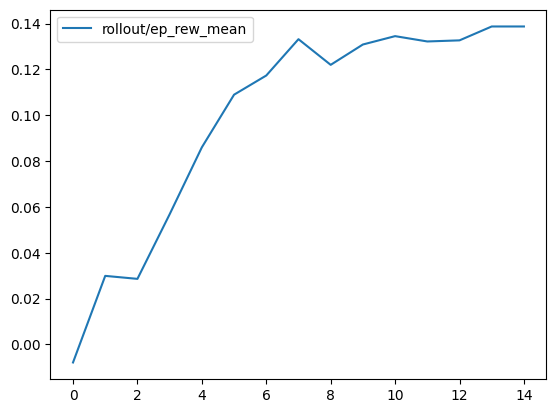

In [ ]:
df.plot(y='rollout/ep_rew_mean')

<Axes: >

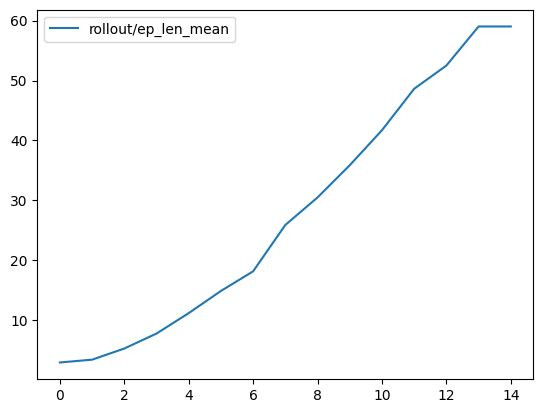

In [ ]:
df.plot(y="rollout/ep_len_mean")